In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [10]:
train= pd.read_csv('PowerAep2.csv')
test= pd.read_csv('PowerTest.csv')

In [11]:
train.head()

,Datetime,AEP_MW
0,12/31/2004 1:00,13478
1,12/31/2004 2:00,12865
2,12/31/2004 3:00,12577
3,12/31/2004 4:00,12517
4,12/31/2004 5:00,12670


In [12]:
train_vals= train.iloc[:, 1:2].values

In [13]:
print(train_vals)

[[13478]
 [12865]
 [12577]
 ...
 [15116]
 [14930]
 [15315]]


In [14]:
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
train_vals_scaled= ss.fit_transform(train_vals)

In [15]:
train_vals_scaled[60]

array([0.52671756])

In [16]:
xtrain=[]
ytrain=[]
for i in range(60,len(train_vals_scaled)):
    xtrain.append(train_vals_scaled[i-60:i,0])
    ytrain.append(train_vals_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [17]:
xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))

In [18]:
xtrain.shape

(1975, 60, 1)

In [19]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
 
MEMORY_LIMIT = 1024
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_LIMIT)])
    except RuntimeError as e:
        print(e)

In [20]:
regression= Sequential()
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
regression.add(Dense(units=1))

regression.compile(optimizer='adam',loss='mean_squared_error')
regression.fit(xtrain,ytrain,batch_size=30,epochs=100)

Epoch 1/100
66/66 [==============================] - 54s 193ms/step - loss: 0.0314
Epoch 2/100
66/66 [==============================] - 12s 180ms/step - loss: 0.0211
Epoch 3/100
66/66 [==============================] - 13s 192ms/step - loss: 0.0194
Epoch 4/100
66/66 [==============================] - 13s 192ms/step - loss: 0.0193
Epoch 5/100
66/66 [==============================] - 13s 191ms/step - loss: 0.0172
Epoch 6/100
66/66 [==============================] - 13s 192ms/step - loss: 0.0148
Epoch 7/100
66/66 [==============================] - 13s 192ms/step - loss: 0.0129
Epoch 8/100
66/66 [==============================] - 13s 192ms/step - loss: 0.0121
Epoch 9/100
66/66 [==============================] - 13s 192ms/step - loss: 0.0112
Epoch 10/100
66/66 [==============================] - 13s 192ms/step - loss: 0.0115
Epoch 11/100
66/66 [==============================] - 13s 192ms/step - loss: 0.0103
Epoch 12/100
66/66 [==============================] - 13s 191ms/step - loss: 0.0100
E

66/66 [==============================] - 13s 191ms/step - loss: 0.0016
Epoch 99/100
66/66 [==============================] - 13s 191ms/step - loss: 0.0016
Epoch 100/100
66/66 [==============================] - 13s 193ms/step - loss: 0.0016


In [22]:
from keras.utils.vis_utils import plot_model
plot_model(regression,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [23]:
test_vals= test.iloc[:, 1:2].values 
total= pd.concat([train['AEP_MW'],test['AEP_MW']],axis=0) # Concating train and test and then will take last 60 train point
test_input = total[len(total)-len(test)-60:].values
test_input= test_input.reshape(-1,1) # reshaping it to get it transformed
test_input= ss.transform(test_input)

In [24]:
xtest= []
for i in range(60,80):
    xtest.append(test_input[i-60:i,0]) #creating input for lstm prediction

In [25]:
xtest= np.array(xtest)

In [26]:
  xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
predicted_value= regression.predict(xtest)

1/1 [==============================] - 7s 7s/step


In [27]:
predicted_value= ss.inverse_transform(predicted_value)

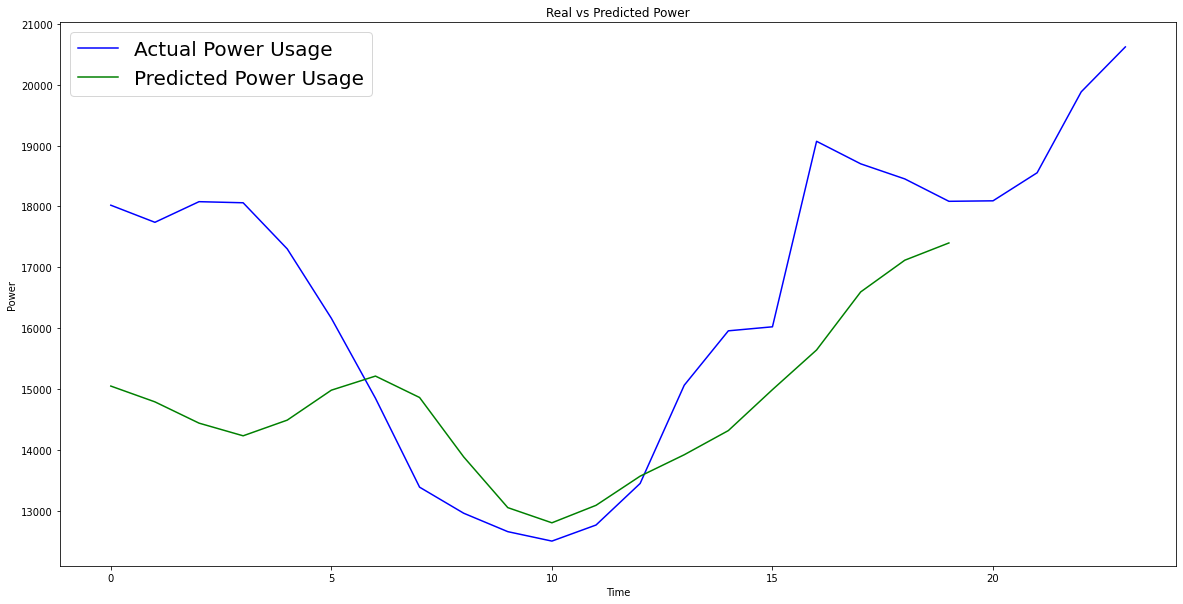

In [28]:
plt.figure(figsize=(20,10))
plt.plot(test_vals,'blue',label='Actual Power Usage')
plt.plot(predicted_value,'green',label='Predicted Power Usage')
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Real vs Predicted Power')
plt.legend(loc='best', fontsize=20)